In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [4]:
# データ準備
beer_parray = pd.read_csv("data/3-6-1-beer-sales-3.csv")
beer_df = pd.DataFrame(beer_parray)

print(beer_parray.shape)
print(beer_parray.head)

(150, 2)
<bound method NDFrame.head of      sales weather
0     48.5  cloudy
1     64.8  cloudy
2     85.8  cloudy
3     45.0  cloudy
4     60.8  cloudy
..     ...     ...
145   50.2   rainy
146   69.9   rainy
147   68.2   rainy
148   47.9   rainy
149   45.0   rainy

[150 rows x 2 columns]>


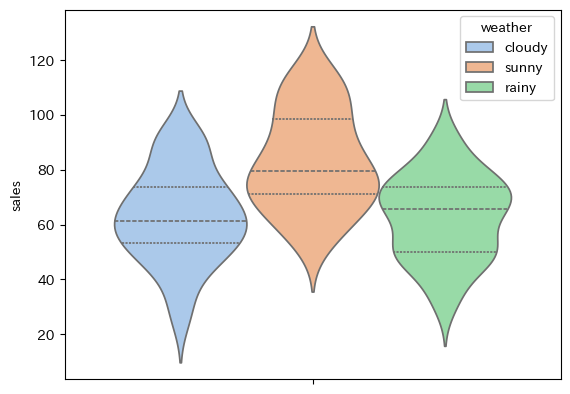

In [5]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.violinplot(hue=beer_parray["weather"], y=beer_parray["sales"], 
                    palette="pastel", inner="quartile")

plt.show();

In [6]:
# データの準備
y = beer_parray["sales"].values
X = pd.get_dummies(beer_df["weather"], dtype=int, drop_first=True)
col_li = X.columns.values # 説明変数の次元指定用に取得
X = X.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(150,)
[48.5 64.8 85.8 45.  60.8 64.  72.6 58.4 91.8 59.9]
(150, 2)
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
['rainy' 'sunny']


## ベイズ推論

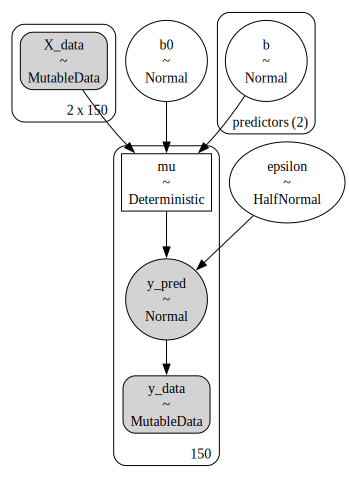

In [7]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X.T, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors")

    # 目的変数の期待値を確率変数として定義
    mu = pm.Deterministic("mu", b @ X_data + b0)

    # 誤差を確率変数として定義
    epsilon = pm.HalfNormal("epsilon", sigma=10000)

    # 観測値を持つ確率変数として定義
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)    

g = pm.model_to_graphviz(model)
display(g)

In [8]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b0, b, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


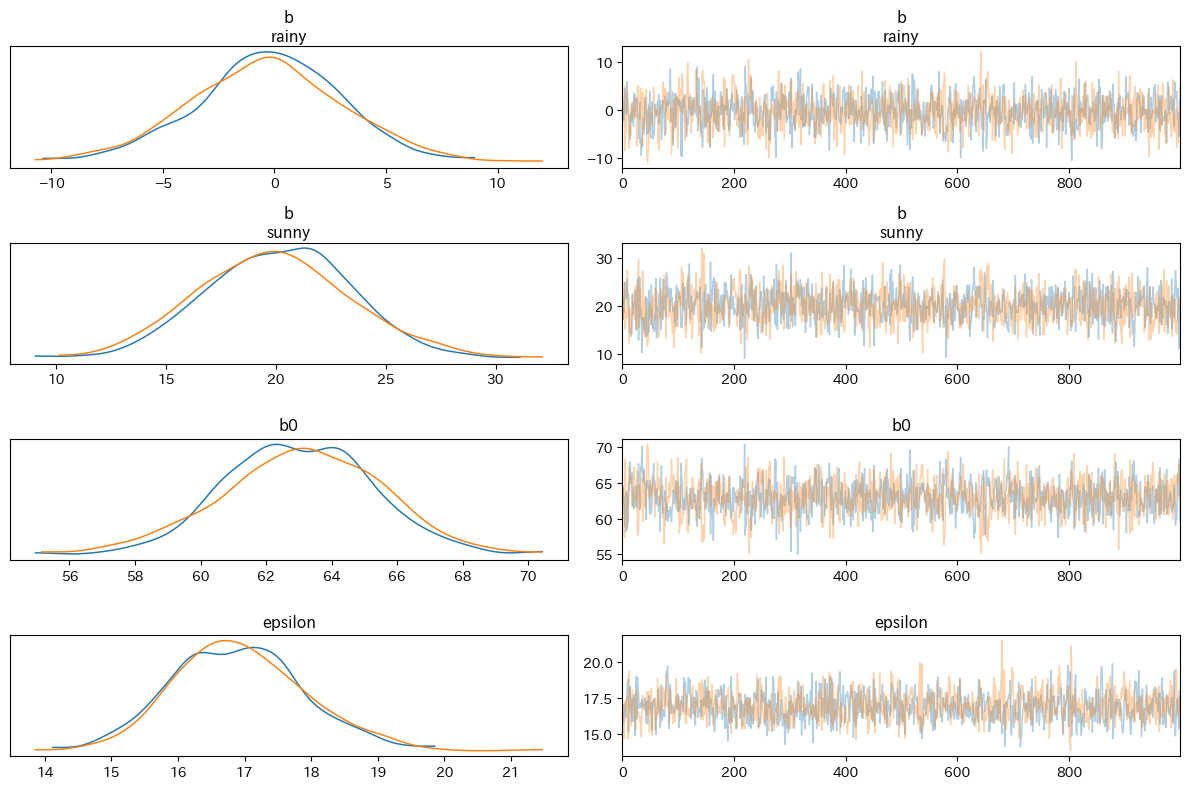

In [9]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0", "epsilon"])
plt.tight_layout();

In [10]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[rainy],-0.316,3.334,-6.848,5.843,0.094,0.066,1261.0,1104.0,1.0
b[sunny],20.021,3.382,13.317,26.038,0.100,0.071,1144.0,1312.0,1.0
b0,63.027,2.334,58.544,67.230,0.070,0.050,1102.0,1047.0,1.0
epsilon,16.917,0.983,15.087,18.799,0.028,0.020,1264.0,1281.0,1.0


,0
count,1000.000000
mean,83.117204
std,2.404550
min,75.729943
5%,79.299165
50%,83.053134
95%,87.138015
max,90.402310


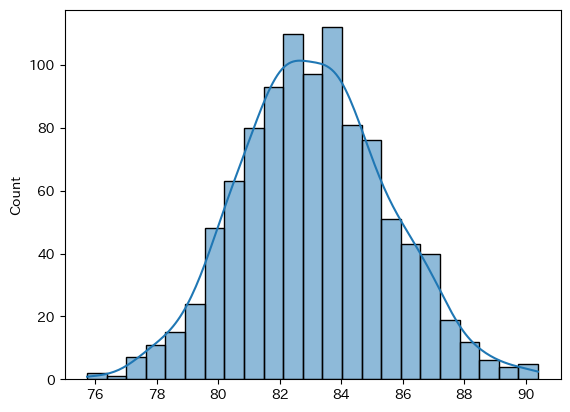

In [11]:
# 晴れのときの、売上の期待値の分布

# パラメータの抽出
b_ifr = idata1["posterior"]["b"].values[0]
b0_ifr = idata1["posterior"]["b0"].values[0]

tmptr = np.array([0, 1]) # 予測用のデータ: 晴れの場合

mu_sunny = b_ifr @ tmptr + b0_ifr # 期待値の計算

# 分布の出力
display(pd.DataFrame(mu_sunny).describe(percentiles=[0.05, 0.95]))

fig, ax = plt.subplots()
ax = sns.histplot(data=mu_sunny, kde=True)

plt.show();